### Feed Forward Networks

<p1><center>Creating differentiable computation graphs for classification tasks.</center></p1>
<img src="img/train.gif">

### Create the data

In [13]:
seed=12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units

In [14]:
X = torch.zeros(N * C, D)
y = torch.zeros(N * C)

for i in range(C):
    index = 0
    r = torch.linspace(0, 1, N)
    t = torch.linspace(
        i * 2 * math.pi / C,
        (i + 2) * 2 * math.pi / C,
        N
    ) + torch.randn(N) * 0.1
    
    for ix in range(N * i, N * (i + 1)):
        X[ix] = r[index] * torch.FloatTensor((
            math.sin(t[index]), math.cos(t[index])
        ))
        y[ix] = i
        index += 1

print("SHAPES:")
print("-------------------")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

SHAPES:
-------------------
X: (3000, 2)
y: (3000,)


In [15]:
def plot_data(X, y, d=.0, auto=False):
    """
    Plot the data.
    """
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis((-1.1, 1.1, -1.1, 1.1))
    if auto is True: plt.axis('equal')
#     plt.savefig('spiral{:.2f}.png'.format(d))

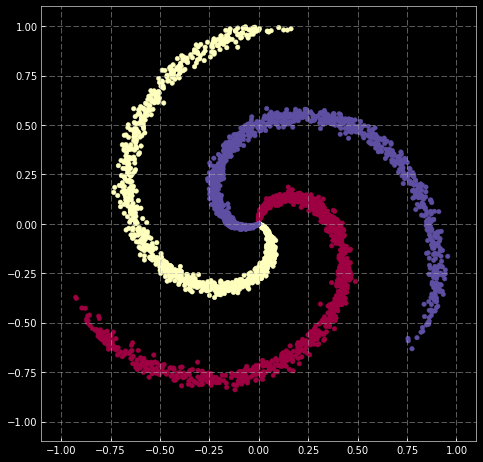

In [16]:
# Create the data
plot_data(X.numpy(), y.numpy())

In [17]:
def plot_model(X, y, model, e=.0, auto=False):
    """
    Plot the model from torch weights.
    """
    
    X = X.numpy()
    y = y.numpy(),
    w1 = torch.transpose(model.fc1.weight.data, 0, 1).numpy()
    b1 = model.fc1.bias.data.numpy()
    w2 = torch.transpose(model.fc2.weight.data, 0, 1).numpy()
    b2 = model.fc2.bias.data.numpy()
    
    h = 0.01

    x_min, x_max = (-1.1, 1.1)
    y_min, y_max = (-1.1, 1.1)
    
    if auto is True:
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], w1) + b1), w2) + b2
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.axis((-1.1, 1.1, -1.1, 1.1))
    plt.axis('square')
    if auto is True:
        plt.axis((xx.min(), xx.max(), yy.min(), yy.max()))
    
#     plt.savefig('train{:03.2f}.png'.format(e))

### Linear model

In [18]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [19]:
# Linear model
class linear_model(nn.Module):
    """
    Linear model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(linear_model, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Forward pass.
        """
        z = self.fc1(x)
        z = self.fc2(z)
        return z

In [20]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = linear_model(D, H, C)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# We convert our inputs and targets to Variables
# so we can use automatic differentiation but we 
# use require_grad=False b/c we don't want the gradients
# to alter these values.
input_X = Variable(X, requires_grad=False)
y_true = Variable(y.long(), requires_grad=False)

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(input_X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y_true)
    score, predicted = torch.max(y_pred, 1)
    acc = (y_true.data == predicted.data).sum() / float(len(y_true))
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.data[0], acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.871214, [ACCURACY]: 0.516


linear_model (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
)


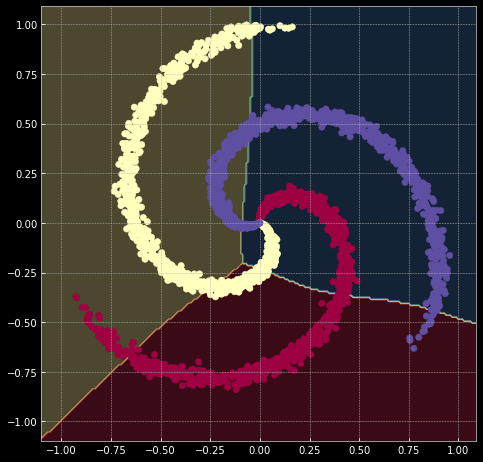

In [21]:
# Plot trained model
print(model)
plot_model(X, y, model)

### Two-layered network

In [22]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [23]:
# NN model
class two_layer_network(nn.Module):
    """
    NN model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(two_layer_network, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Forward pass.
        """
        z = F.relu(self.fc1(x))
        z = self.fc2(z)
        return z

In [24]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = two_layer_network(D, H, C)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# We convert our inputs and targest to Variables
# so we can use automatic differentiation but we 
# use require_grad=False b/c we don't want the gradients
# to alter these values.
input_X = Variable(X, requires_grad=False)
y_true = Variable(y.long(), requires_grad=False)

# e = 1.  # plotting purpose

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(input_X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y_true)
    score, predicted = torch.max(y_pred, 1)
    acc = (y_true.data == predicted.data).sum() / float(len(y_true))
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.data[0], acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()
    
#    # Plot some progress
#     if t % math.ceil(e) == 0:
#         plot_model(X, y, model, e)
#         e *= 1.5

#! convert -delay 20 -crop 500x475+330+50 +repage $(gls -1v train*) train.gif

[EPOCH]: 999, [LOSS]: 0.176190, [ACCURACY]: 0.945


two_layer_network (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
)


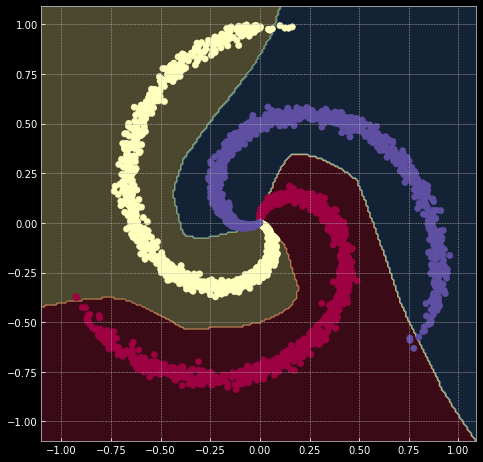

In [25]:
# Plot trained model
print(model)
plot_model(X, y, model)

### Proper training procedure

#### Create datasets

In [26]:
split_ratio = 0.8 # train-test split
num_epochs = 100
batch_size = 64
log_every = 25

In [27]:
# Shuffle and split the data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]
test_start_idx = int(len(X) * split_ratio)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 2400 train samples and 600 test samples.


In [28]:
# Join X and y
train_data = torch.cat([X_train, y_train], 1)
test_data = torch.cat([X_test, y_test], 1)

In [29]:
# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

#### Training

In [30]:
learning_rate = 1e-3
lambda_l2 = 1e-5
dropout_p = 0.1
decay_rate = 0.9999
max_grad_norm = 5.0

In [31]:
# Linear model
class customized_network(nn.Module):
    """
    Custom model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(customized_network, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)
        self.dropout = nn.Dropout(dropout_p)
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        """
        Properly initialize weights.
        """
        init.xavier_uniform(self.fc1.weight, gain=np.sqrt(2.0)) # gain for ReLU

    def forward(self, x):
        """
        Forward pass.
        """
        z = F.relu(self.fc1(x))
        z = self.dropout(z)
        z = self.fc2(z)
        return z

In [32]:
def process_batch(batch, model, criterion, optimizer, is_training):
    """
    Process a minibatch for loss and accuracy.
    """
    X_batch = batch[:,:2]
    y_batch = batch[:, 2]

    # Convert tensors to Variables (for autograd)
    X_batch = Variable(X_batch, requires_grad=False)
    y_batch = Variable(y_batch.long(), requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        
        # Clip the gradient norms
        nn.utils.clip_grad_norm(model.parameters(), max_grad_norm)

        # Update params
        optimizer.step()

    return loss, accuracy

In [33]:
def plot_metrics(train_loss, train_acc, test_loss, test_acc):
    """
    Plot the global metrics.
    """
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    
    ax1.plot(train_loss, label='train loss')
    ax1.plot(test_loss, label='test loss')
    ax1.legend(loc=3)
    ax1.set_title('Loss')
    
    ax2.plot(train_acc, label='train accuracy')
    ax2.plot(test_acc, label='test accuracy')
    ax2.legend(loc=4)
    ax2.set_title('Accuracy')
    
    f.tight_layout()

In [34]:
def proper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False):
    """
    Training with a few extra (nice) components.
    """
    
    # Metrics
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (train_batch) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(train_batch, model, criterion, optimizer, model.training)

            # Add to batch scalars
            train_batch_loss += loss.data[0] / float(len(train_batch))
            train_batch_accuracy += accuracy
            
        # Add to global metrics
        train_loss.append(train_batch_loss/float(train_batch_num+1))
        train_acc.append(train_batch_accuracy/float(train_batch_num+1))

        # Testing
        model.eval()
        for num_test_epoch in range(1):

            # Metrics
            test_batch_loss = 0.0
            test_batch_accuracy = 0.0

            for test_batch_num, (test_batch) in enumerate(test_loader):

                # Get metrics
                model.eval()
                loss, accuracy = \
                    process_batch(test_batch, model, criterion, optimizer, model.training)

                # Add to batch scalars
                test_batch_loss += loss.data[0] / float(len(test_batch))
                test_batch_accuracy += accuracy

            # Add to global metrics
            test_loss.append(test_batch_loss/float(test_batch_num+1))
            test_acc.append(test_batch_accuracy/float(test_batch_num+1))
                
            if animate:
                verbose_condition = num_train_epoch == num_epochs-1
                if num_train_epoch%10 == 0:
                    plot_model(X, y, model)
                    display.clear_output(wait=True)
            else:
                verbose_condition = \
                    (num_train_epoch == 0) or (num_train_epoch % log_every == 0) or (num_train_epoch == num_epochs-1)

            # Verbose
            if verbose_condition:

                # Verbose
                time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
                minutes = time_remain // 60
                seconds = time_remain - minutes*60
                print("TIME REMAINING: %im %is" % (minutes, seconds))
                print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                       (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                        train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                        test_batch_accuracy/float(test_batch_num+1)))
            
    # Plot global metrics
    plot_metrics(train_loss, train_acc, test_loss, test_acc)
    
    return model

TIME REMAINING: 0m 4s
[EPOCH]: 0, [TRAIN LOSS]: 0.016939, [TRAIN ACC]: 0.467, [TEST LOSS]: 0.018552, [TEST ACC]: 0.483
TIME REMAINING: 0m 2s
[EPOCH]: 25, [TRAIN LOSS]: 0.006580, [TRAIN ACC]: 0.824, [TEST LOSS]: 0.007254, [TEST ACC]: 0.816
TIME REMAINING: 0m 2s
[EPOCH]: 50, [TRAIN LOSS]: 0.003925, [TRAIN ACC]: 0.910, [TEST LOSS]: 0.004037, [TEST ACC]: 0.921
TIME REMAINING: 0m 1s
[EPOCH]: 75, [TRAIN LOSS]: 0.002976, [TRAIN ACC]: 0.939, [TEST LOSS]: 0.002942, [TEST ACC]: 0.956
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.002423, [TRAIN ACC]: 0.949, [TEST LOSS]: 0.002424, [TEST ACC]: 0.974


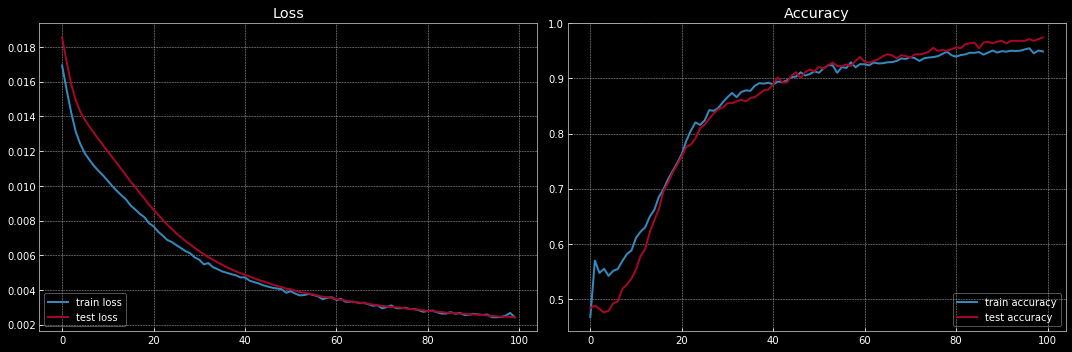

In [35]:
# Create model
model = customized_network(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Train
model = proper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm)

customized_network (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
  (dropout): Dropout (p = 0.1)
)


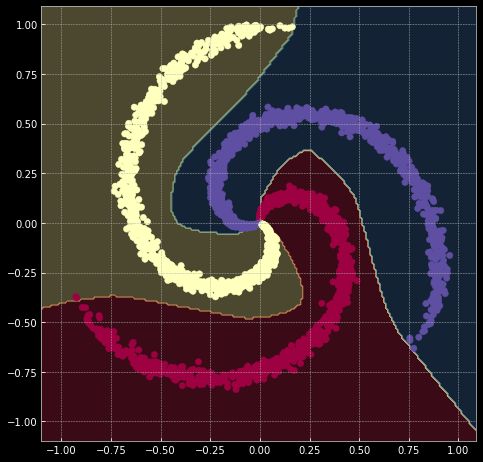

In [36]:
# Plot trained model
print(model)
plot_model(X, y, model)

### Save/load models

In [39]:
# Save the model
torch.save(model, "model.pt")

/Users/atcold/miniconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type customized_network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [40]:
# Load the model
model = torch.load(os.path.join("model.pt"))

### Inference

In [41]:
X_infer = Variable(X[0].view(1, -1))
y_infer = Variable(y[:1])
print("X_infer:\n", X_infer)
print("y_infer:\n", y_infer)

X_infer:
 Variable containing:
-0.6483  0.2814
[torch.FloatTensor of size 1x2]

y_infer:
 Variable containing:
 1
[torch.FloatTensor of size 1]



In [42]:
# Feed through model to get probs
model.eval()
scores = model(X_infer)
probabilities = F.softmax(scores)

# Sorted probabilities
sorted_, indices = torch.sort(probabilities, descending=True)
for i, index in enumerate(indices[0]):
    print("%i - %i%%" % (
        indices[0].data[i],
        100.0*probabilities.data[0][index.data[0]]))

1 - 99%
2 - 0%
0 - 0%


### Hyperparameters

Let's see how changing our hyperparameters can alter the model.

TIME REMAINING: 0m 4s
[EPOCH]: 0, [TRAIN LOSS]: 0.016920, [TRAIN ACC]: 0.477, [TEST LOSS]: 0.018543, [TEST ACC]: 0.508
TIME REMAINING: 0m 2s
[EPOCH]: 25, [TRAIN LOSS]: 0.007243, [TRAIN ACC]: 0.782, [TEST LOSS]: 0.008082, [TEST ACC]: 0.779
TIME REMAINING: 0m 2s
[EPOCH]: 50, [TRAIN LOSS]: 0.004512, [TRAIN ACC]: 0.885, [TEST LOSS]: 0.004741, [TEST ACC]: 0.876
TIME REMAINING: 0m 1s
[EPOCH]: 75, [TRAIN LOSS]: 0.003698, [TRAIN ACC]: 0.907, [TEST LOSS]: 0.003628, [TEST ACC]: 0.915
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.003257, [TRAIN ACC]: 0.925, [TEST LOSS]: 0.003124, [TEST ACC]: 0.930


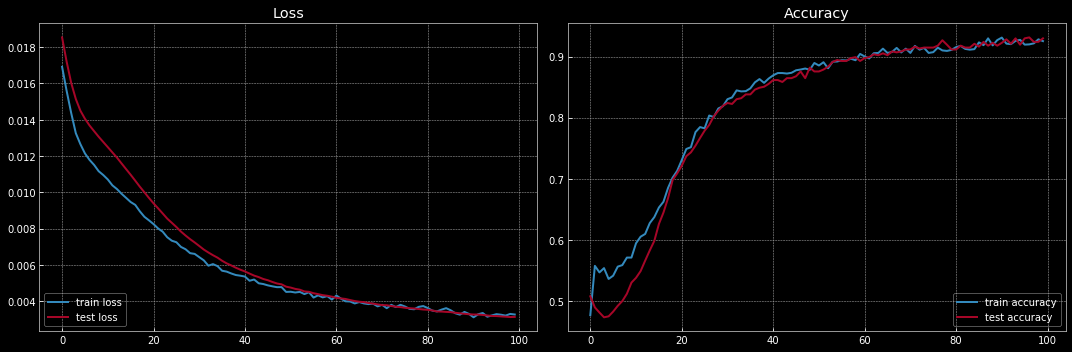

In [43]:
model = customized_network(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

learning_rate = 1e-3
lambda_l2 = 1e-5
dropout_p = 0.1
decay_rate = 0.9999
max_grad_norm = 5.0

model = proper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False)

customized_network (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
  (dropout): Dropout (p = 0.1)
)


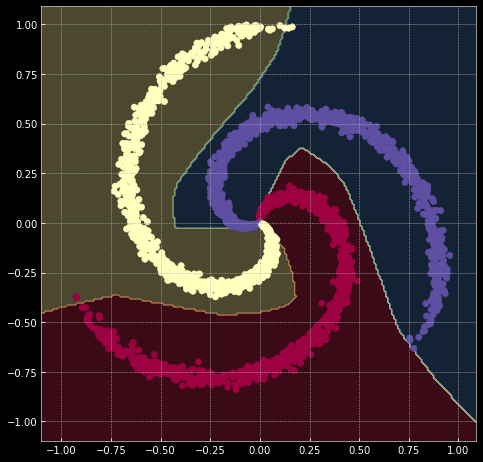

In [44]:
# Plot trained model
print(model)
plot_model(X, y, model)